<img src="https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo_new_2.png" width="10%">
<h1><center>Computer Vision Project Template (Image Classification)</center></h1>

---

For this notebook, we will be using the Project Template.

The goal of the template is to make the Capstone Project implementation easy for the user.

# ML Project

There are 5 core components of a ML Project:
- Problem Statement
- Dataset
- DL Model
- Model Training
- Model Evaluation

The Template provides wrappers (Data and Model classes) and an API (ModelEngine) that works hand-in-hand with a Configuration. Together, they form a complete Training API.


Download and install the template

In [1]:
# !git clone https://github.com/jjaskirat/wcd_project_template.git
# %cd wcd_project_template
# ! python setup.py install
# %cd ..

Imports

In [2]:
import time
import os
import copy
from typing import Optional

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import random
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

/home/jaskirat/wcd_project_template/venv-wcd-t/lib/python3.12/site-packages/tqdm-4.67.0-py3.12.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problem Statement

---

Aircraft, and in particular airplanes, are alternative to objects typically considered for fine-grained categorization such as birds and pets. There are several aspects that make aircraft model recognition particularly interesting. Firstly, aircraft designs span a hundred years, including many thousand different models and hundreds of different makes and airlines. Secondly, aircraft designs vary significantly depending on the size (from home-built to large carriers), destination (private, civil, military), purpose (transporter, carrier, training, sport, fighter, etc.), propulsion (glider, propeller, jet), and many other factors including technology. One particular axis of variation, which is is not shared with categories such as animals, is the fact that the structure of the aircraft changes with their design (number of wings, undercarriages, wheel per undercarriage, engines, etc.). Thirdly, any given aircraft model can be re-purposed or used by different companies, which causes further variations in appearance (livery). These, depending on the identification task, may be consider as noise or as useful information to be extracted. Finally, aircraft are largely rigid objects, which simplifies certain aspects of their modeling (compared to highly-deformable animals such as cats), allowing one to focus on the core aspects of the fine-grained recognition problem.

## Dataset

---

**Content**

The dataset contains 10,000 images of aircraft, The data is split into 3334 training images, 3333 validation and 3333 testing images
Aircraft models are organized in a four-levels hierarchy. The four levels, from finer to coarser, are:

Model, e.g. Boeing 737-76J. Since certain models are nearly visually indistinguishable, this level is not used in the evaluation.
Variant, e.g. Boeing 737-700. A variant collapses all the models that are visually indistinguishable into one class. The dataset comprises 100 different variants.
Family, e.g. Boeing 737. The dataset comprises 70 different families.
Manufacturer, e.g. Boeing. The dataset comprises 41 different manufacturers.

**csv files**

the csv files makes easy way to use the dataset. By Separate dataset into 3 file that is train,val and test
It contains 3 columns:
filename: image file name
Classes: Variant Classes name e.g. 707-320, A318
Labels: Categorical Value for the Classes that is 0-99 for 100 Classes

**Acknowledgements**

Data source: http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/
Please use the following citation when referring to this dataset:

Fine-Grained Visual Classification of Aircraft, S. Maji, J. Kannala, E. Rahtu, M. Blaschko, A. Vedaldi, arXiv.org, 2013

Download the dataset from Kaggle

In [3]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("seryouxblaster764/fgvc-aircraft")

print("Path to dataset files:", data_dir)
print("Contents of Data Dir: ", os.listdir(data_dir))

Path to dataset files: /home/jaskirat/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2
Contents of Data Dir:  ['val.csv', 'fgvc-aircraft-2013b', 'train.csv', 'test.csv']


In [4]:
# Show the img_dir

img_dir = f'{data_dir}/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images'
print("Contents of Img Dir: ", os.listdir(img_dir)[:5])

Contents of Img Dir:  ['2104253.jpg', '2106315.jpg', '0078364.jpg', '1785531.jpg', '1369907.jpg']


### Data Exploration and Visualization



In this section, we will be exploring the data and checking for class balancing

In [5]:
def plot_plane_data_classes(df, img_dir: os.PathLike[str], num_classes: int=20, figsize=(24, 32)):
    """
    This function selects num_classes random labels from the df
    Then plots 5 images from each class in 2 columns
    """
    # subplot of 2 columns
    fig, ax = plt.subplots(num_classes // 2, 2, figsize=figsize)
    fig.tight_layout(h_pad = 2)
    # randomly select num_classes labels
    labels = df['Labels'].unique()
    labels = random.sample(list(labels), num_classes)
    # loop through the labels
    for idx, i in enumerate(labels):
        # Get images corresponding to the label
        filenames = list(df[df['Labels'] == i]['filename'])
        random.shuffle(filenames)
        concat_imgs = []
        # for each label
        # Get 5 random images
        for j in range(5):
            imgName = img_dir + "/" + filenames[j]
            img = cv2.imread(imgName)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            concat_imgs.append(img)
        # Merge 5 imgs of same class to 1
        concat_img = cv2.hconcat(concat_imgs)
        # Plot them on respective ax, column
        ax[idx//2, (idx%2)].imshow(concat_img)
        ax[idx//2, (idx%2)].set_title(i, fontsize=10)
        ax[idx//2, (idx%2)].set_yticks([])
        ax[idx//2, (idx%2)].set_xticks([])
    plt.title('Class Plots')
    plt.show()

def check_dataset_balancing(df):
    # Plot histogram to check class balancing
    df['Labels'].hist()
    plt.title('Class Distribution')
    plt.show()

In [6]:
# Read the Train/ Val and Test DataFrames
# Note that the Train/ Val and Test images are already provided to us

df_train =  pd.read_csv(f'{data_dir}/train.csv')
df_valid =  pd.read_csv(f'{data_dir}/val.csv')
df_test =  pd.read_csv(f'{data_dir}/test.csv')

print('Train Size   : ', len(df_train))
print('Val Size     : ', len(df_valid))
print('Test Size    : ', len(df_test))

### Explore and Visualize

Training Data

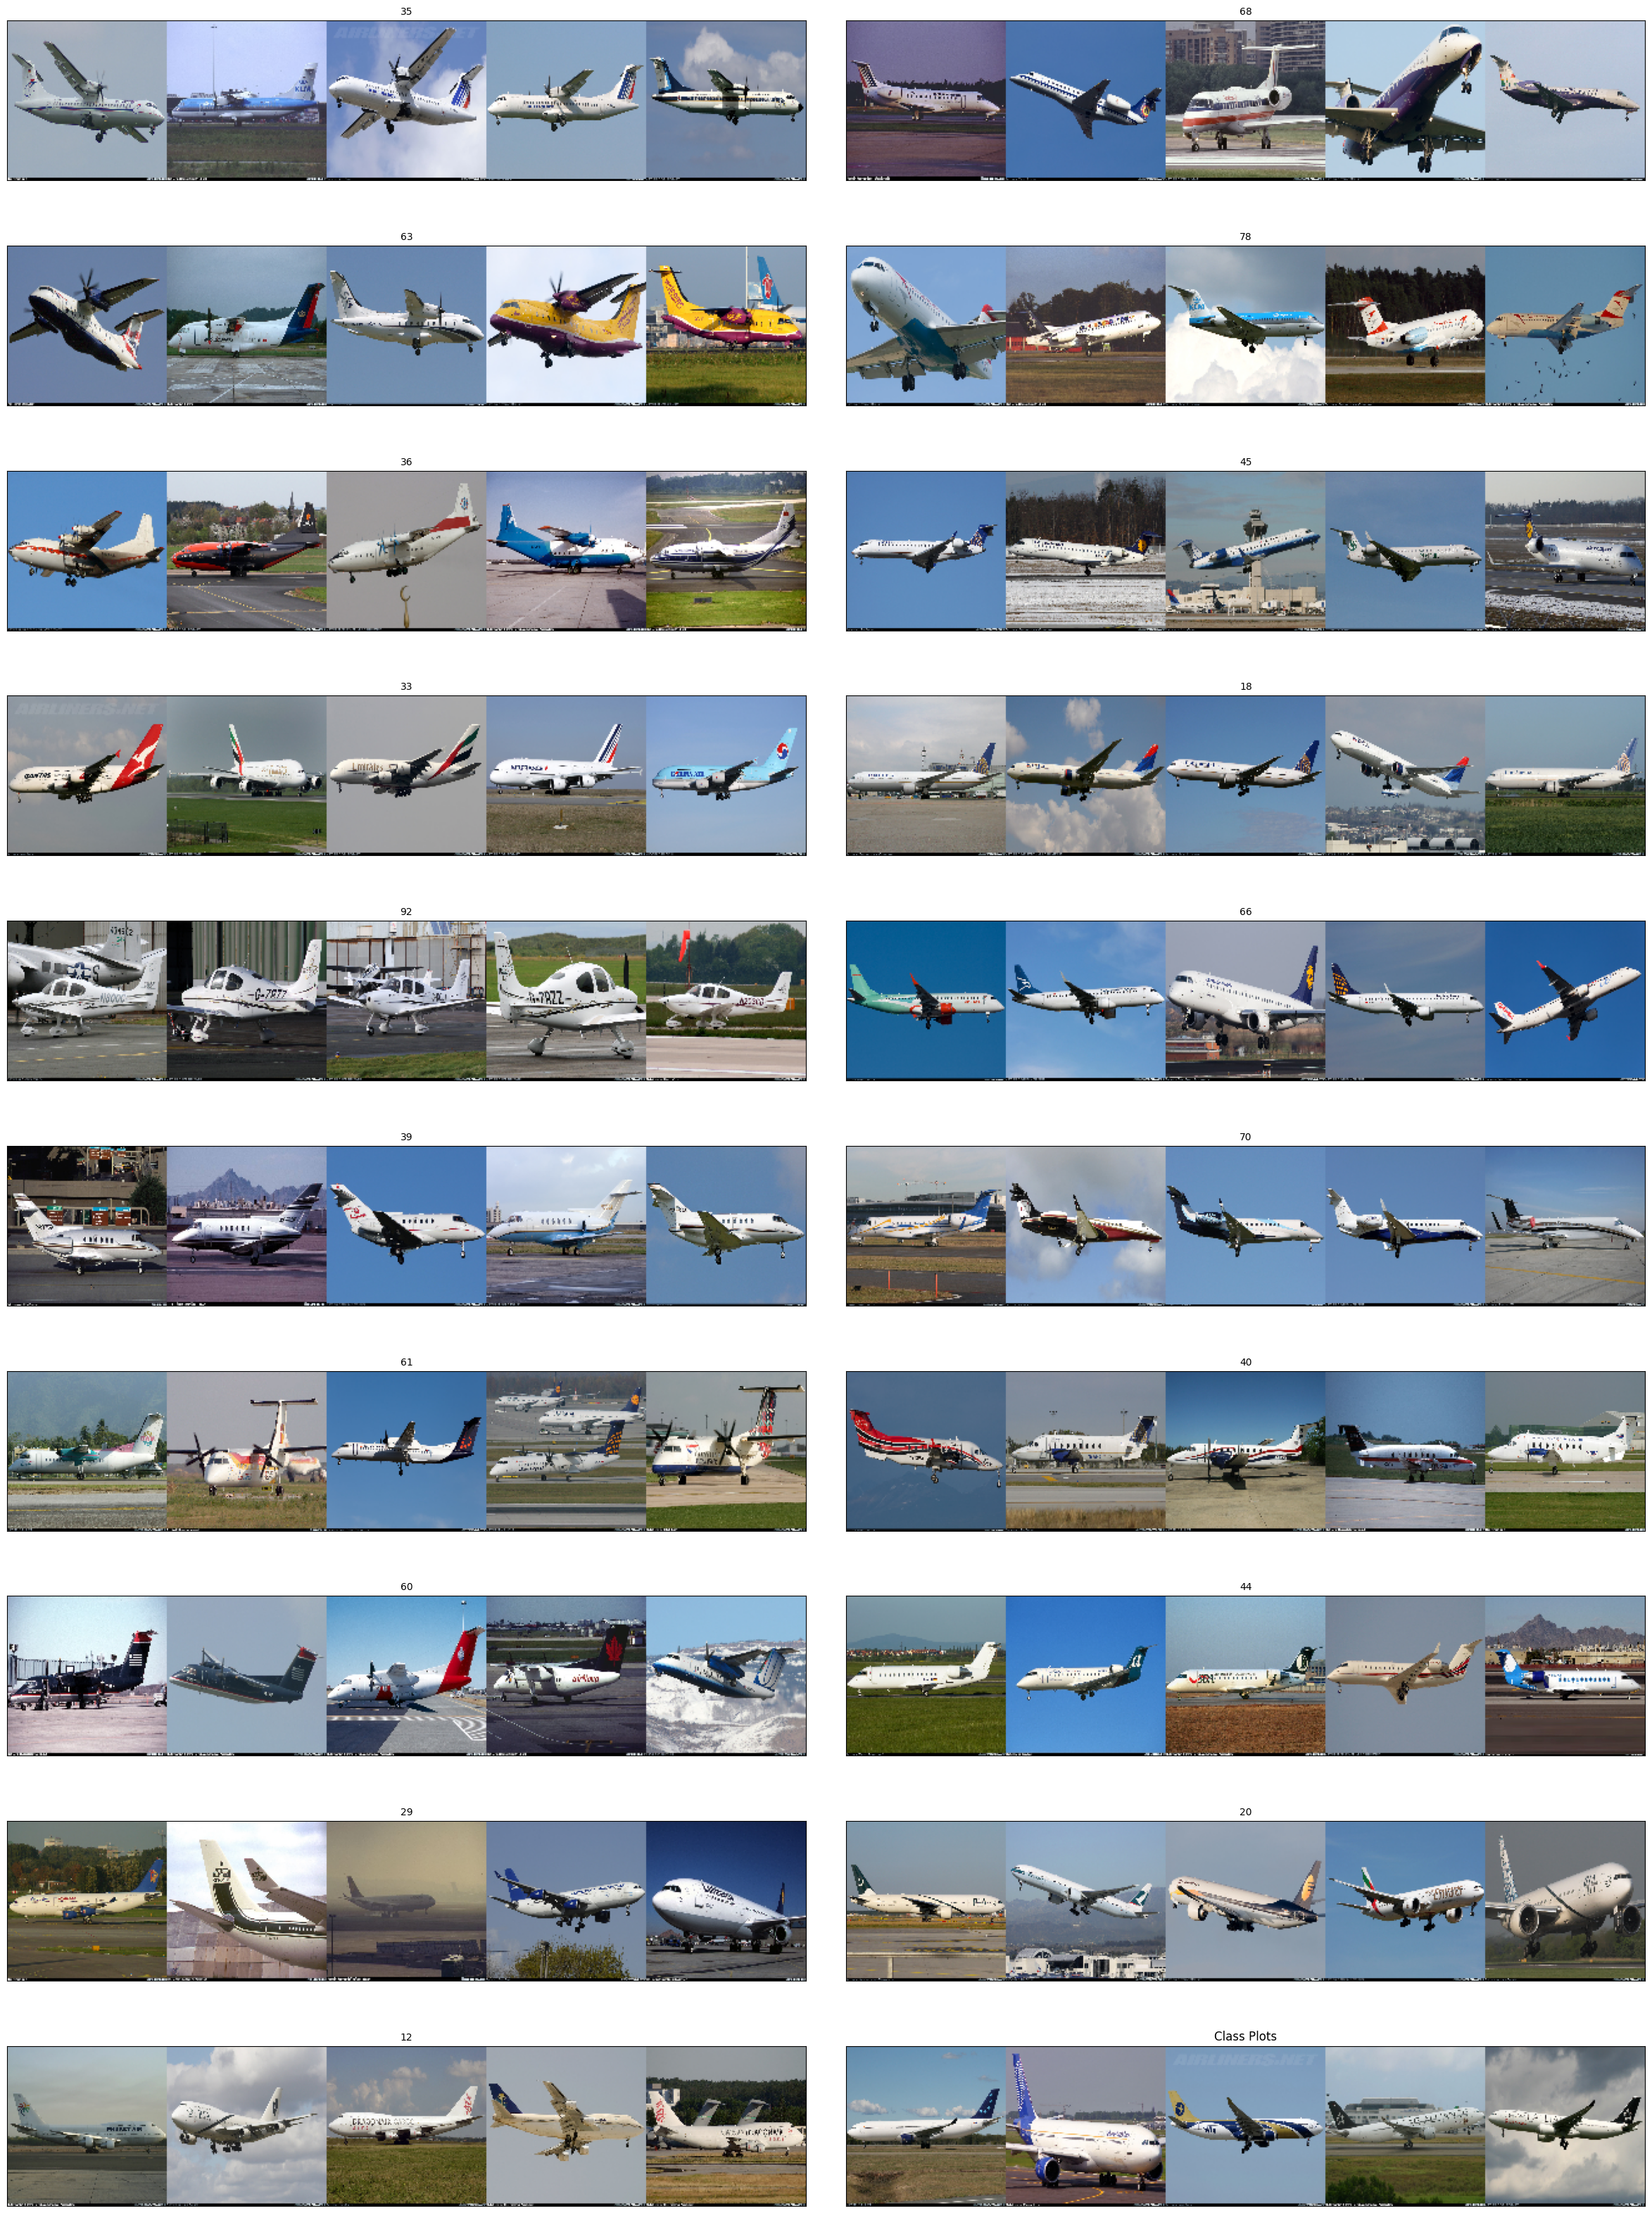

In [7]:
plot_plane_data_classes(df_train, img_dir)

# You can use the following code to get more images

# plot_plane_data_classes(df_train, img_dir, num_classes=10, img_size=(24, 32))
# plot_plane_data_classes(df_train, img_dir, num_classes=50, img_size=(24, 32))
# plot_plane_data_classes(df_train, img_dir, num_classes=100, img_size=(24, 32))

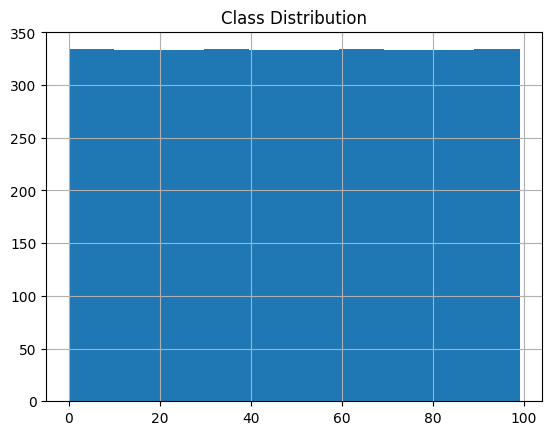

In [8]:
check_dataset_balancing(df_train)

### Explore and Visualize

Validation Data

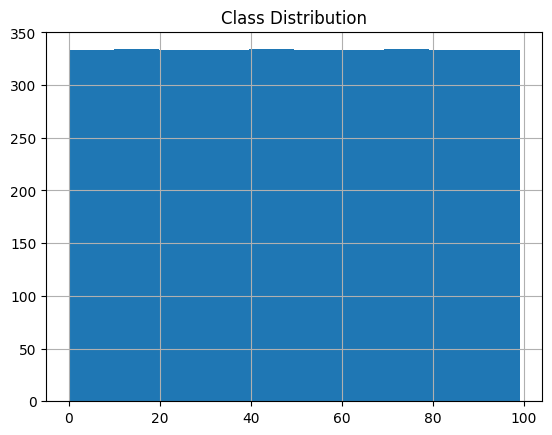

In [10]:
# plot_plane_data_classes(df_valid, img_dir)

check_dataset_balancing(df_valid)

### Explore and Visualize

Testing Data

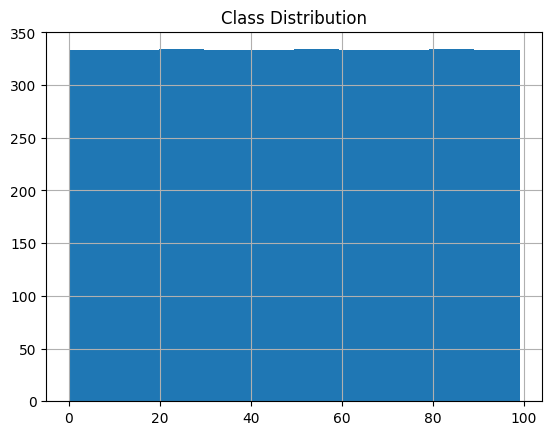

In [12]:
# plot_plane_data_classes(df_test, img_dir)

check_dataset_balancing(df_test)

### Inference from plots:

- Some of the images are black and white
- The data is uniformly distributed among the class labels

## Dataset Creation

The template provides a wrapper on top of a torch Dataset.

The user is responsible to create their own dataset and load it in PyTorch.

The `Data` class inherits from the `torch.utils.data.Dataset` class. It implements the `__len__` and the `__getitem__` functions. The user must implement the `get_input`, `get_label` and `apply_transform` functions, which define how the input and the labels can be obtained from a `pd.core.frame.DataFrame`

In [13]:
# Import Data from the template
from wcd_project_template.data import Data

In [14]:
class DataClassification(Data):
    def __init__(
            self,
            df,
            config_data: dict,
            transform: Optional[A.Compose] = None
        ):
        super().__init__(df, config_data, transform)

    def get_input(self, row):
        """gets the input from the df row

        Returns:
            np.ndarray: the image
        """
        input_path = os.path.join(self.root_dir, row['filename'])
        input = cv2.imread(input_path)
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        return input

    def get_label(self, row):
        """gets the label from the df row

        Returns:
            Union[np.ndarray, int]: the label
        """
        label = row['Labels']
        return label

    def apply_transform(self, input, label):
        """applies the transformation on both the image and the label respectively. For classification, we do not need to apply any transformation on the label.

        Returns:
            Tuple[np.ndarray, int, torch.Tensor]: the transformed images and labels
        """
        input = self.transform(image=input)['image']
        return input, label

Define the Transforms

In [15]:
# We will use the Albumentations Library for transforms
# https://albumentations.ai/docs/

# Selected Transforms:
# - Resize
# - Horizontal Flip
# - GridDistortion
# - RandomBrightnessContrast
# - GaussNoise
# - Normalize according to Imagenet Mean and Std
# - Convert to Tensor

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Train Transforms
transforms_train = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise(p=0.8),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
        ),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

# Validation Transforms
# Note: In validation transforms, we do not add the Horizontal Flip transform
transforms_valid = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
        ),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

# Validation Inverse Transforms
# This essentially does an unnormalize on the image.
# We can use this transformation to get the original
# image back after applying the transforms to it
transforms_valid_inverse = A.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

The `Data` configuration consists of the `root_dir` to specify where the images are present. Then it consists of a `dataloader` where you can specify the kwargs for `torch.utils.data.DataLoader`

In [16]:
# Training Data config
config_dataset_train = {
    'root_dir': img_dir,
    'dataloader': {
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 4
    },
}

# Validation data config
config_dataset_valid = {
    'root_dir': img_dir,
    'dataloader': {
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },
}

Creating the Datasets

In [17]:
# Training Data
data_train = DataClassification(
    df_train,
    config_dataset_train,
    transform=transforms_train
)
# Validation Data
data_valid = DataClassification(
    df_valid,
    config_dataset_valid,
    transform=transforms_valid
)
# Testing Data
data_test = DataClassification(
    df_test,
    config_dataset_valid,
    transform=transforms_valid
)

## DL Model

---

he template provides a wrapper on top of a torch model. The template provides the usage of 3 different libraries:
- `timm`, `segmentation-models-pytorch` and `detectron2`

For Classification Purposes:
- timm
    - [Github and Documentation](https://github.com/huggingface/pytorch-image-models/tree/main)
    - comprehensive list of encoders or classification models,
    - Ex: Resnet, ViT, Mobilenet, etc
    - The timm module takes care of modifying the final classification layer.

In [18]:
# Import Model from the template
from wcd_project_template.model import Model

In [19]:
# List all timm models
timm.list_models(pretrained=True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

The `Model` configuration consists of the `model_hyperparameters` to specify the parameters of the model. Then it consists of a `weights_path` where you can load pretrained model_weights from. Finally a `freeze_layer` which specifies the layers you want to freeze (perform no backpropagation on)

In [20]:
config_model = {
    'model_hyperparameters':{
        'pretrained': True,
        'in_chans': 3,
        'num_classes': 100
    },
    'weights_path': None,
    'freeze_layers': [],
}

model_ = timm.create_model(model_name='resnet101', **config_model['model_hyperparameters'])
model = Model(model_, config_model)

done loading model


In [21]:
model.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

## Model Training

---

The template provides you with a `ModelEngine` class. This class is responsible for supervised model training and evaluation. The code for training or evaluating the model is generally the same for every model. The components that change are the `Loss`, `Metric` and `Optimizer`.
- Loss
    - The loss function can be imported from any library
    - It can also be a custom loss function as seen [here](https://discuss.pytorch.org/t/custom-loss-functions/29387/2)
- Metric
    - Any metric can be used from the library `torchmetrics`.
    - Options for a custom metric are also provided [here](https://lightning.ai/docs/torchmetrics/stable/pages/implement.html)
- Optimizer
    - The optimizer must be from the `torch.optim` module.
    - Any optimizer can be selected
    - Options for a custom optimizer are also provided on the docs

In [22]:
# Import ModelEngine from the template
from wcd_project_template.model_engine import ModelEngine

Create the Model Engine

In [23]:
engine = ModelEngine('cuda')

The Model Engine config consists of the training parameters like `num_epochs`, then it contains sections where you can modify the `criterion`, `metric` and `optimizer`

The `name` parameter is a string corresponding to the import string of the Class. Except for the Optimizer, where it is the optimizer name

The `config` is the kwargs for the Class imported from the `name` parameter



In [24]:
config_training = {
    'num_epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'config': {
            'lr': 0.001,
            'weight_decay': 1e-5
        },
    },
    'criterion': {
        'name': 'torch.nn.CrossEntropyLoss',
        'config': {},
    },
    'metric':{
        'name': 'torchmetrics.Accuracy',
        'config':{
            'task': 'multiclass',
            'num_classes': 100,
        }
    }
}

config_evaluation = {
    'criterion': {
        'name': 'torch.nn.CrossEntropyLoss',
        'config': {},
    },
    'metric':{
        'name': 'torchmetrics.Accuracy',
        'config':{
            'task': 'multiclass',
            'num_classes': 100,
        }
    }
}

In [25]:
trained_model, training_meta_data = engine.train(
    model,
    data_train,
    data_valid,
    config_training,
    config_evaluation
)

Total Training Samples:  3334


  4%|▍         | 1/25 [00:18<07:35, 18.97s/it]

Epoch-1: 
Training: Loss = 4.6140, Accuracy = 0.0199, Time = 14.16 seconds
Validation: Loss = 4.5218, Accuracy = 0.0318, Time = 4.81 seconds



  8%|▊         | 2/25 [00:38<07:19, 19.12s/it]

Epoch-2: 
Training: Loss = 3.5913, Accuracy = 0.1461, Time = 14.53 seconds
Validation: Loss = 2.5032, Accuracy = 0.2787, Time = 4.70 seconds



 12%|█▏        | 3/25 [00:57<06:58, 19.03s/it]

Epoch-3: 
Training: Loss = 1.9832, Accuracy = 0.4067, Time = 14.32 seconds
Validation: Loss = 1.7472, Accuracy = 0.4683, Time = 4.59 seconds



 16%|█▌        | 4/25 [01:15<06:36, 18.88s/it]

Epoch-4: 
Training: Loss = 1.2609, Accuracy = 0.6062, Time = 13.95 seconds
Validation: Loss = 1.3706, Accuracy = 0.5740, Time = 4.69 seconds



 20%|██        | 5/25 [01:34<06:15, 18.78s/it]

Epoch-5: 
Training: Loss = 0.8802, Accuracy = 0.7197, Time = 13.99 seconds
Validation: Loss = 1.2883, Accuracy = 0.6262, Time = 4.61 seconds



 24%|██▍       | 6/25 [01:53<05:56, 18.74s/it]

Epoch-6: 
Training: Loss = 0.6801, Accuracy = 0.7834, Time = 14.07 seconds
Validation: Loss = 1.2738, Accuracy = 0.6358, Time = 4.61 seconds



 28%|██▊       | 7/25 [02:11<05:36, 18.70s/it]

Epoch-7: 
Training: Loss = 0.5325, Accuracy = 0.8273, Time = 13.96 seconds
Validation: Loss = 1.4013, Accuracy = 0.6469, Time = 4.66 seconds



 32%|███▏      | 8/25 [02:30<05:17, 18.67s/it]

Epoch-8: 
Training: Loss = 0.4831, Accuracy = 0.8492, Time = 14.02 seconds
Validation: Loss = 1.2028, Accuracy = 0.6865, Time = 4.59 seconds



 36%|███▌      | 9/25 [02:48<04:58, 18.65s/it]

Epoch-9: 
Training: Loss = 0.3668, Accuracy = 0.8858, Time = 13.96 seconds
Validation: Loss = 1.5446, Accuracy = 0.6265, Time = 4.65 seconds



 40%|████      | 10/25 [03:07<04:38, 18.56s/it]

Epoch-10: 
Training: Loss = 0.3512, Accuracy = 0.8900, Time = 13.78 seconds
Validation: Loss = 1.2538, Accuracy = 0.6925, Time = 4.57 seconds



 44%|████▍     | 11/25 [03:25<04:19, 18.54s/it]

Epoch-11: 
Training: Loss = 0.2891, Accuracy = 0.9110, Time = 13.90 seconds
Validation: Loss = 1.1640, Accuracy = 0.7144, Time = 4.61 seconds



 48%|████▊     | 12/25 [03:44<04:00, 18.54s/it]

Epoch-12: 
Training: Loss = 0.2379, Accuracy = 0.9207, Time = 13.87 seconds
Validation: Loss = 1.3487, Accuracy = 0.6910, Time = 4.66 seconds



 52%|█████▏    | 13/25 [04:02<03:42, 18.55s/it]

Epoch-13: 
Training: Loss = 0.2462, Accuracy = 0.9188, Time = 13.99 seconds
Validation: Loss = 1.2958, Accuracy = 0.6829, Time = 4.60 seconds



 56%|█████▌    | 14/25 [04:21<03:24, 18.59s/it]

Epoch-14: 
Training: Loss = 0.1996, Accuracy = 0.9365, Time = 14.05 seconds
Validation: Loss = 1.4233, Accuracy = 0.6907, Time = 4.61 seconds



 60%|██████    | 15/25 [04:40<03:05, 18.58s/it]

Epoch-15: 
Training: Loss = 0.2011, Accuracy = 0.9425, Time = 13.97 seconds
Validation: Loss = 1.3083, Accuracy = 0.6934, Time = 4.59 seconds



 64%|██████▍   | 16/25 [04:58<02:47, 18.61s/it]

Epoch-16: 
Training: Loss = 0.1830, Accuracy = 0.9444, Time = 14.08 seconds
Validation: Loss = 1.3325, Accuracy = 0.7066, Time = 4.59 seconds



 68%|██████▊   | 17/25 [05:17<02:29, 18.64s/it]

Epoch-17: 
Training: Loss = 0.1989, Accuracy = 0.9383, Time = 13.96 seconds
Validation: Loss = 1.3688, Accuracy = 0.6727, Time = 4.77 seconds



 72%|███████▏  | 18/25 [05:36<02:12, 18.87s/it]

Epoch-18: 
Training: Loss = 0.1738, Accuracy = 0.9449, Time = 14.57 seconds
Validation: Loss = 1.5050, Accuracy = 0.6631, Time = 4.81 seconds



 76%|███████▌  | 19/25 [05:56<01:54, 19.10s/it]

Epoch-19: 
Training: Loss = 0.1794, Accuracy = 0.9464, Time = 14.77 seconds
Validation: Loss = 1.2277, Accuracy = 0.7195, Time = 4.87 seconds



 80%|████████  | 20/25 [06:15<01:35, 19.14s/it]

Epoch-20: 
Training: Loss = 0.1177, Accuracy = 0.9637, Time = 14.45 seconds
Validation: Loss = 1.4443, Accuracy = 0.7009, Time = 4.78 seconds



 84%|████████▍ | 21/25 [06:34<01:16, 19.13s/it]

Epoch-21: 
Training: Loss = 0.1283, Accuracy = 0.9625, Time = 14.36 seconds
Validation: Loss = 1.4358, Accuracy = 0.6907, Time = 4.74 seconds



 88%|████████▊ | 22/25 [06:54<00:57, 19.14s/it]

Epoch-22: 
Training: Loss = 0.1153, Accuracy = 0.9623, Time = 14.41 seconds
Validation: Loss = 1.5979, Accuracy = 0.6796, Time = 4.76 seconds



 92%|█████████▏| 23/25 [07:13<00:38, 19.13s/it]

Epoch-23: 
Training: Loss = 0.1808, Accuracy = 0.9434, Time = 14.38 seconds
Validation: Loss = 1.5471, Accuracy = 0.6766, Time = 4.73 seconds



 96%|█████████▌| 24/25 [07:32<00:19, 19.15s/it]

Epoch-24: 
Training: Loss = 0.1380, Accuracy = 0.9545, Time = 14.43 seconds
Validation: Loss = 1.5827, Accuracy = 0.6667, Time = 4.76 seconds



100%|██████████| 25/25 [07:51<00:00, 18.86s/it]

Epoch-25: 
Training: Loss = 0.1199, Accuracy = 0.9630, Time = 14.43 seconds
Validation: Loss = 1.3631, Accuracy = 0.6991, Time = 4.74 seconds



### Training Plots

Loss plot

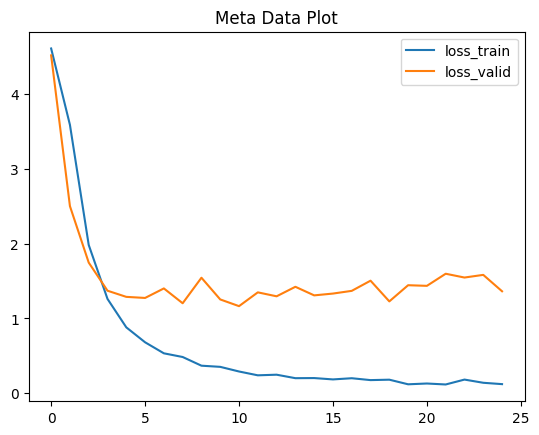

In [26]:
engine.plot(training_meta_data, ['loss_train', 'loss_valid'])

Metric Plot

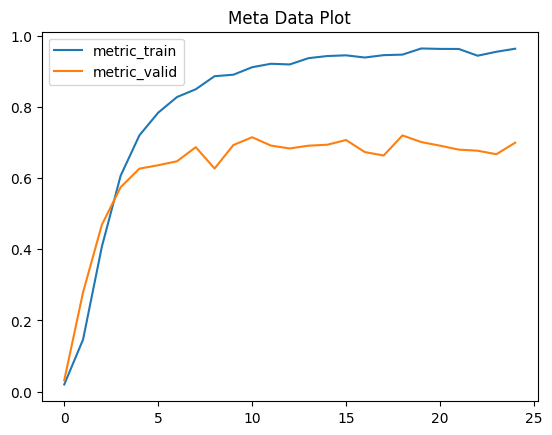

In [27]:
engine.plot(training_meta_data, ['metric_train', 'metric_valid'])

## Model Evaluation

---

The model can be evaluated similar to the training method. By specifying the trained_model, data_test and the config_evaluation

In [28]:
engine.evaluate(
    trained_model,
    data_test,
    config_evaluation
)

(1.3934838771820068, 0.7074707746505737)

We can see that the model has a 70.75% accuracy on the Test Set

---
---